<a href="https://colab.research.google.com/github/AgustinaInsua/TP-LABO-GRUPO4/blob/main/kmeans-pca-t-sne-2cvs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar las librerias

In [157]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
from scipy.spatial import QhullError



Leer el archivo .csv

In [158]:
# URLs de los tres archivos de datos para diferentes años
urls = [
    'https://raw.githubusercontent.com/AgustinaInsua/TP-LABO-GRUPO4/main/info2020-21.csv',
    'https://raw.githubusercontent.com/AgustinaInsua/TP-LABO-GRUPO4/main/info2018-19.csv'
]

# Función para asignar una región a cada provincia (mismas regiones que en tu código)
def assign_region(province):
    if province in ['Corrientes', 'Chaco', 'Misiones', 'Formosa', 'Entre Ríos']:
        return 'Nordeste-Litoral'
    elif province in ['Tucumán', 'Jujuy', 'Salta', 'Catamarca', 'Santiago del Estero']:
        return 'Noroeste'
    elif province in ['San Luis', 'San Juan', 'Mendoza', 'La Rioja']:
        return 'Cuyo'
    elif province in ['Neuquén', 'Río Negro', 'La Pampa']:
        return 'Patagonia Centro-Norte'
    elif province in ['Tierra del Fuego', 'Santa Cruz', 'Chubut']:
        return 'Patagonia Centro-Sur'
    elif province == 'Santa Fe':
        return 'Santa Fe'
    elif province == 'Buenos Aires provincia':
        return 'Buenos Aires'
    elif province == 'Córdoba':
        return 'Córdoba'
    else:
        return 'CABA'

# Cargar y procesar los datos de los tres años
data_frames = []
nrows_to_read = 1000  #  filas a cargar
for url in urls:
    data = pd.read_csv(url, nrows=nrows_to_read)
    data['provincia_nombre'] = data['provincia_nombre'].str.replace('"', '')
    data['REGION'] = data['provincia_nombre'].apply(assign_region)
    data_frames.append(data)

# Combinar los DataFrames en uno solo
combined_data = pd.concat(data_frames, ignore_index=True)
combined_data



,departamento_id,departamento_nombre,provincia_id,provincia_nombre,anio,semanas_epidemiologicas,evento_nombre,grupo_edad_id,grupo_edad_desc,cantidad_casos,REGION
0,42,GENERAL SAN MART?N,14,Córdoba,2020,47,Enfermedad tipo influenza (ETI),5,5 a 9,1,Córdoba
1,42,GENERAL SAN MART?N,14,Córdoba,2020,47,Enfermedad tipo influenza (ETI),9,25 a 34,1,Córdoba
2,70,LA PAZ,30,Entre Ríos,2020,28,Enfermedad tipo influenza (ETI),3,12 a 23 m,1,Nordeste-Litoral
3,70,LA PAZ,30,Entre Ríos,2020,28,Enfermedad tipo influenza (ETI),4,2 a 4,2,Nordeste-Litoral
4,70,LA PAZ,30,Entre Ríos,2020,28,Enfermedad tipo influenza (ETI),5,5 a 9,1,Nordeste-Litoral
...,...,...,...,...,...,...,...,...,...,...,...
1995,91,PUNILLA,14,Cordoba,2018,42,Enfermedad tipo influenza (ETI),4,2 a 4,2,CABA
1996,14,CAPITAL,14,Cordoba,2018,42,Bronquiolitis en menores de 2 anos,2,6 a 11 m,1,CABA
1997,63,LA CAPITAL,82,Santa Fe,2018,19,Bronquiolitis en menores de 2 anos,1,< 6 m,2,Santa Fe
1998,119,25 DE MAYO,54,Misiones,2018,33,Enfermedad tipo influenza (ETI),2,6 a 11 m,1,Nordeste-Litoral


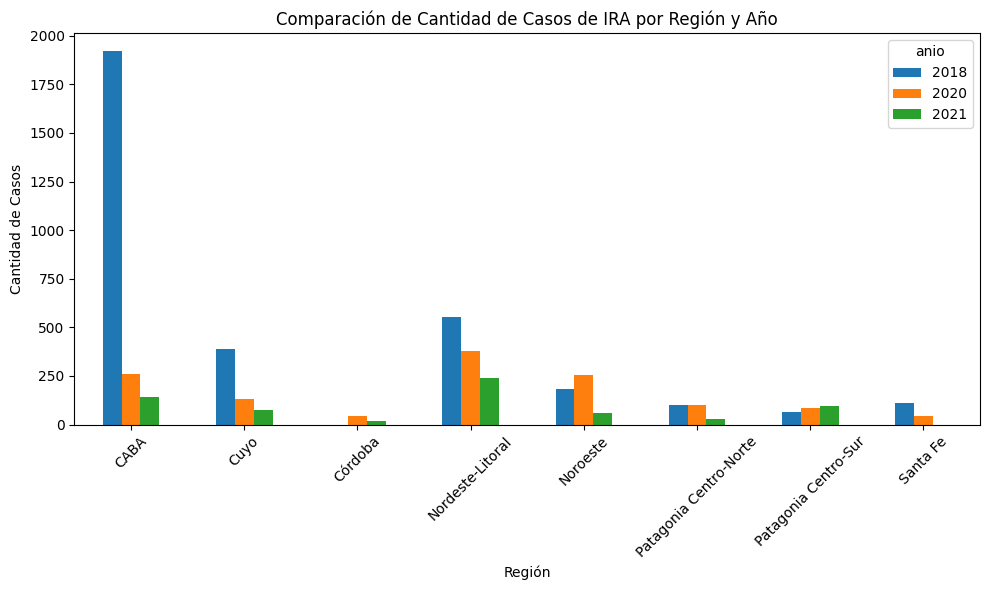

In [159]:
# Análisis comparativo: Cantidad total de casos por región y año
cases_by_region_year = combined_data.groupby(['REGION', 'anio']).agg({'cantidad_casos': 'sum'}).reset_index()

# Visualización: Gráfico de barras comparativo por región y año
pivot_table = cases_by_region_year.pivot(index='REGION', columns='anio', values='cantidad_casos')
pivot_table.plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Cantidad de Casos de IRA por Región y Año')
plt.xlabel('Región')
plt.ylabel('Cantidad de Casos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [160]:
columns_to_drop = ['REGION', 'provincia_nombre', 'departamento_nombre','departamento_id', 'grupo_edad_desc', 'semanas_epidemiologicas']
data = data.drop(columns=columns_to_drop)
data

,provincia_id,anio,evento_nombre,grupo_edad_id,cantidad_casos
0,22,2018,Enfermedad tipo influenza (ETI),1,1
1,22,2018,Enfermedad tipo influenza (ETI),2,3
2,22,2018,Enfermedad tipo influenza (ETI),3,5
3,22,2018,Enfermedad tipo influenza (ETI),4,8
4,22,2018,Enfermedad tipo influenza (ETI),5,4
...,...,...,...,...,...
995,14,2018,Enfermedad tipo influenza (ETI),4,2
996,14,2018,Bronquiolitis en menores de 2 anos,2,1
997,82,2018,Bronquiolitis en menores de 2 anos,1,2
998,54,2018,Enfermedad tipo influenza (ETI),2,1


In [161]:
# Asignaciones para columnas no númericas
assignment_mapping = {
    'evento_nombre': {
        'Bronquiolitis en menores de 2 años': 2,
        'Enfermedad tipo influenza (ETI)': 3,
        'Neumonía': 1
    }
}

# Limpia valores de las columnas antes de asignar
string_columns = ['evento_nombre']
for column in string_columns:
    data[column] = data[column].str.strip('"')  # Elimina comillas
    data[column] = data[column].str.strip()     # Elimina espacios en blanco

# Aplica las asignaciones
for column, mapping in assignment_mapping.items():
    data[column] = data[column].map(mapping)
data



,provincia_id,anio,evento_nombre,grupo_edad_id,cantidad_casos
0,22,2018,3.0,1,1
1,22,2018,3.0,2,3
2,22,2018,3.0,3,5
3,22,2018,3.0,4,8
4,22,2018,3.0,5,4
...,...,...,...,...,...
995,14,2018,3.0,4,2
996,14,2018,NaN,2,1
997,82,2018,NaN,1,2
998,54,2018,3.0,2,1


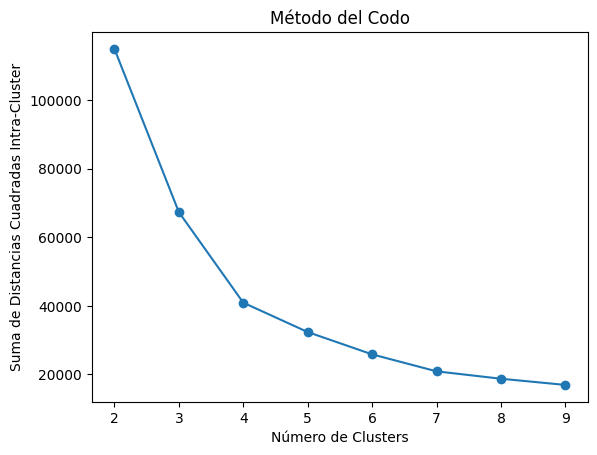

In [162]:

data = data.dropna()   #borra filas con NaN
inertia_values = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
    kmeans.fit(data)
    inertia_values.append(kmeans.inertia_)

# Grafica la suma de las distancias cuadradas intra-cluster en función de k
plt.plot(range(2, 10), inertia_values, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de Distancias Cuadradas Intra-Cluster')
plt.title('Método del Codo')
plt.show()

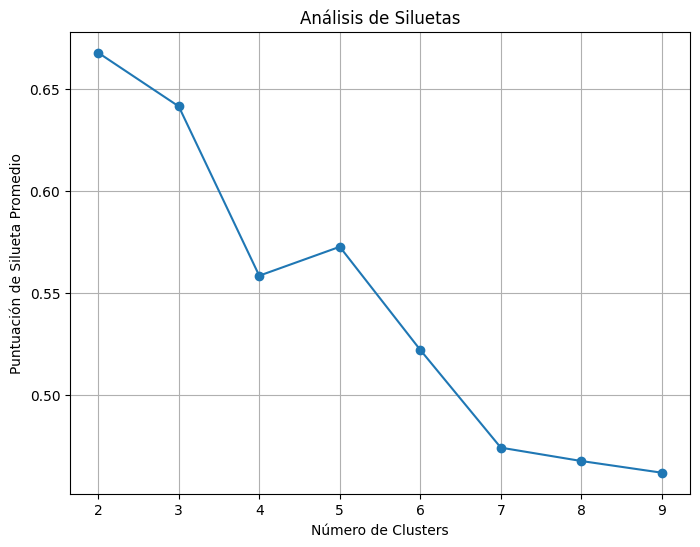

In [163]:
from sklearn.metrics import silhouette_samples, silhouette_score

scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
    cluster_labels = kmeans.fit_predict(data)

    silhouette_avg = silhouette_score(data, cluster_labels)
    scores.append(silhouette_avg)

    sample_silhouette_values = silhouette_samples(data, cluster_labels)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntuación de Silueta Promedio')
plt.title('Análisis de Siluetas')
plt.grid(True)
plt.show()

In [180]:
# Aplicamos K-Means para clasificar las regiones en grupos
kmeans = KMeans(n_clusters=6, n_init=100, random_state=0).fit(data)

# Asigna un color a cada región en base a los clusters
data['Cluster'] = kmeans.labels_

<ipython-input-180-fb706545b16b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.labels_


<ipython-input-182-3671167bfcf3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tsne_x'] = tsne_coordinates[:, 0]
<ipython-input-182-3671167bfcf3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tsne_y'] = tsne_coordinates[:, 1]
<ipython-input-182-3671167bfcf3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

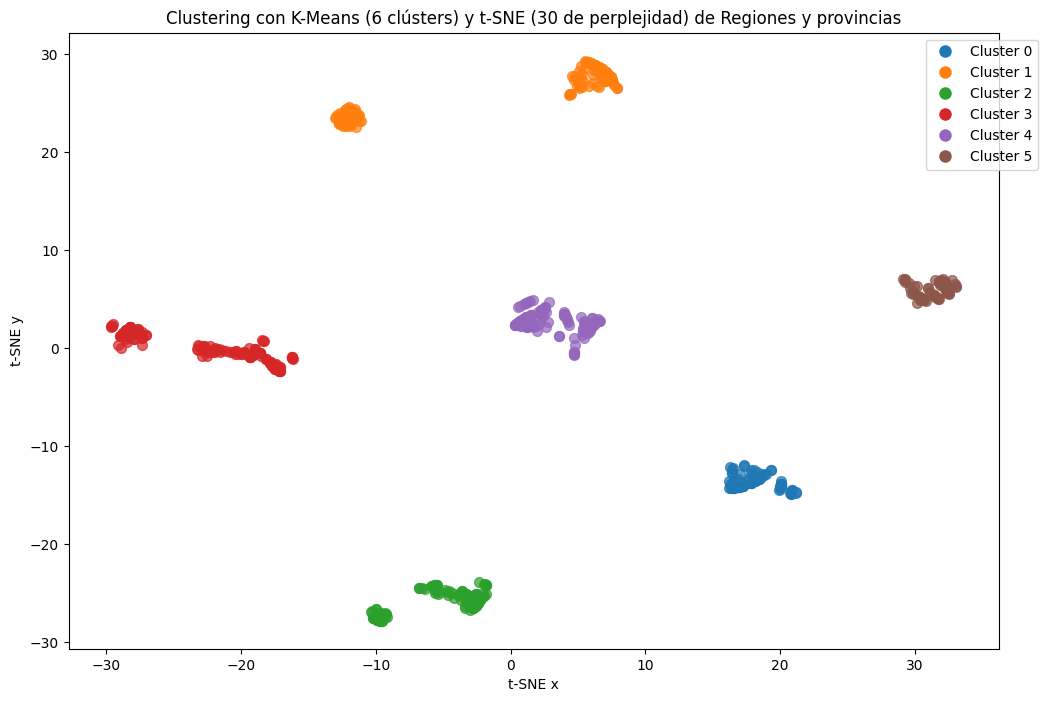

In [182]:
# Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_coordinates = tsne.fit_transform(data)
data['tsne_x'] = tsne_coordinates[:, 0]
data['tsne_y'] = tsne_coordinates[:, 1]

# Generación de colores para los clusters
cluster_colors = plt.cm.tab10.colors
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(kmeans.labels_)
data['provincia_id'] = data['provincia_id']
for cluster in unique_clusters:
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['tsne_x'], cluster_data['tsne_y'],
                label=f'Cluster {cluster}', alpha=0.7, s=50)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=f'C{cluster}', markersize=10, label=f'Cluster {cluster}') for cluster in unique_clusters]

# Coloca la leyenda al costado del gráfico
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.title('Clustering con K-Means (6 clústers) y t-SNE (30 de perplejidad) de Regiones y provincias')
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.show()

<ipython-input-183-c1ff23129c38>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pca_x'] = pca_coordinates[:, 0]
<ipython-input-183-c1ff23129c38>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pca_y'] = pca_coordinates[:, 1]
<ipython-input-183-c1ff23129c38>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

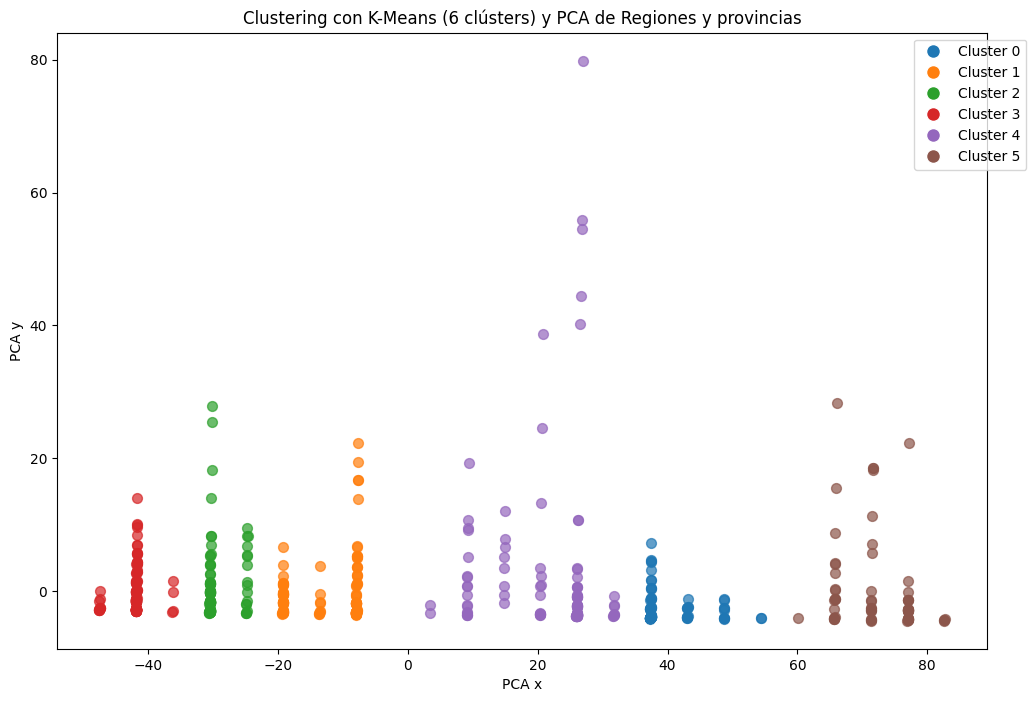

In [183]:
from sklearn.decomposition import PCA

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
pca_coordinates = pca.fit_transform(data.drop(['tsne_x', 'tsne_y'], axis=1))

data['pca_x'] = pca_coordinates[:, 0]
data['pca_y'] = pca_coordinates[:, 1]

# Generación de colores para los clusters
cluster_colors = plt.cm.tab10.colors
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(kmeans.labels_)
data['provincia_id'] = data['provincia_id']
for cluster in unique_clusters:
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['pca_x'], cluster_data['pca_y'],
                label=f'Cluster {cluster}', alpha=0.7, s=50)

# Crear elementos para la leyenda
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=f'C{cluster}', markersize=10, label=f'Cluster {cluster}') for cluster in unique_clusters]

# Colocar la leyenda al costado del gráfico
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.title('Clustering con K-Means (6 clústers) y PCA de Regiones y provincias')
plt.xlabel('PCA x')
plt.ylabel('PCA y')
plt.show()

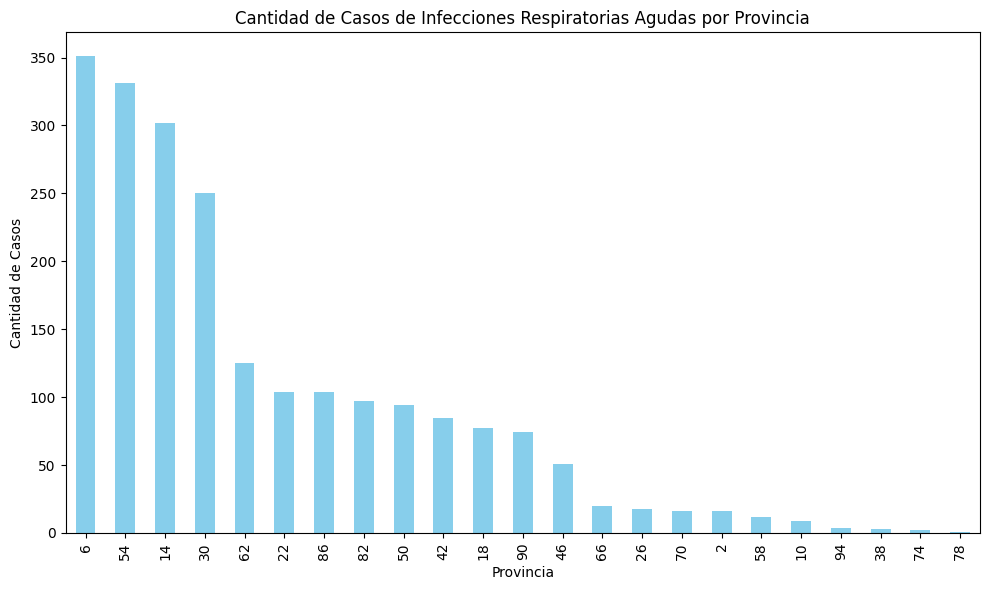

In [184]:
# Agrupar por provincia y sumar la cantidad de casos
provincia_cases = data.groupby('provincia_id')['cantidad_casos'].sum()

# Ordenar de mayor a menor cantidad de casos
provincia_cases = provincia_cases.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
provincia_cases.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Casos de Infecciones Respiratorias Agudas por Provincia')
plt.xlabel('Provincia')
plt.ylabel('Cantidad de Casos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()